## Fiancial Market Segmentation and Prediction Using Neural Networks and Clustering
The objective is this project is to develop a hybrid model that segments financial market data using clustering techniques and then predicts future market trends within each segment using neural networks.

In [10]:
import yfinance as yf
import pandas as pd

# List of stock tickers
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'JPM', 'JNJ', 'WMT', 'PG', 'XOM', 'BRK-B', 'V', 'PG', 'NVDA', 'KO', 'JNJ']

# Download historical data for multiple stocks
data = yf.download(tickers, start='2010-01-01', end='2023-12-31')

#Display head of data
data.head()

[*********************100%%**********************]  13 of 13 completed


Price      Adj Close                                                      \
Ticker          AAPL    AMZN      BRK-B      GOOGL        JNJ        JPM   
Date                                                                       
2010-01-04  6.461977  6.6950  66.220001  15.666453  42.308624  29.335232   
2010-01-05  6.473147  6.7345  66.540001  15.597464  41.818039  29.903452   
2010-01-06  6.370184  6.6125  66.199997  15.204272  42.158165  30.067762   
2010-01-07  6.358408  6.5000  66.459999  14.850323  41.857281  30.663357   
2010-01-08  6.400682  6.6760  66.440002  15.048295  42.001190  30.588051   

Price                                                  ...     Volume  \
Ticker             KO       MSFT      NVDA         PG  ...      GOOGL   
Date                                                   ...              
2010-01-04  18.209940  23.389404  0.423988  39.663845  ...   78169752   
2010-01-05  17.989656  23.396954  0.430179  39.676830  ...  120067812   
2010-01-06  17.983269  23.253370  0.432931  39.488651  ...  158988852   
2010-01-07  17.938572  23.011538  0.424447  39.274494  ...  256315428   
2010-01-08  17.606554  23.170244  0.425364  39.222569  ...  188783028   

Price                                                                   \
Ticker           JNJ       JPM        KO      MSFT       NVDA       PG   
Date                                                                     
2010-01-04   9506200  35460500  13870400  38409100  800204000  9190800   
2010-01-05  10673100  41208300  23172400  49749600  728648000  8649400   
2010-01-06  13171500  27729000  19264600  58182400  649168000  9908400   
2010-01-07  10901600  44864700  13234600  50559700  547792000  8972800   
2010-01-08   7898000  33110100  28712400  51197400  478168000  8464600   

Price                                     
Ticker             V       WMT       XOM  
Date                                      
2010-01-04  20180000  62259300  27809100  
2010-01-05  25833600  46945200  30174700  
2010-01-06  16254000  37551600  35044700  
2010-01-07  27841200  31988100  27192100  
2010-01-08  11907200  34089600  24891800  

[5 rows x 78 columns]

## Data Preprocessing
Now that the data has been collected we will preprocess the data. We will handle missing values and incorrect data types, removing duplicates, normalize the data, and engineer features that will be usefull for clustering and predictions.

In [28]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Forward fill and backward fill missing values
data.ffill(inplace=True)
data.bfill(inplace=True)

# Drop duplicates
data = data.drop_duplicates()

# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
cols_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume']

# Normalize columns efficiently
for col in cols_to_normalize:
    cols = [(col, ticker) for ticker in tickers if (col, ticker) in data.columns]
    data[cols] = scaler.fit_transform(data[cols])

# Function to add features
def add_features(df, ticker):
    df[('Returns', ticker)] = df[('Close', ticker)].pct_change()
    df[('Volatility', ticker)] = df[('Returns', ticker)].rolling(window=21).std()
    df[('MA_50', ticker)] = df[('Close', ticker)].rolling(window=50).mean()
    df[('MA_200', ticker)] = df[('Close', ticker)].rolling(window=200).mean()
    return df

# Apply feature engineering for each ticker
for ticker in tickers:
    data = add_features(data, ticker)

# Convert date index to datetime if not already
data.index = pd.to_datetime(data.index)

# Display a sample of the processed data
print(data.head())

# Verify calculations further down the DataFrame
for ticker in tickers:
    print(data[[('Returns', ticker), ('Volatility', ticker), ('MA_50', ticker), ('MA_200', ticker)]].tail(60))


Price      Adj Close                                                      \
Ticker          AAPL    AMZN      BRK-B      GOOGL        JNJ        JPM   
Date                                                                       
2010-01-04  6.461977  6.6950  66.220001  15.666453  42.308624  29.335232   
2010-01-05  6.473147  6.7345  66.540001  15.597464  41.818039  29.903452   
2010-01-06  6.370184  6.6125  66.199997  15.204272  42.158165  30.067762   
2010-01-07  6.358408  6.5000  66.459999  14.850323  41.857281  30.663357   
2010-01-08  6.400682  6.6760  66.440002  15.048295  42.001190  30.588051   

Price                                                  ... MA_50 MA_200  \
Ticker             KO       MSFT      NVDA         PG  ...     V      V   
Date                                                   ...                
2010-01-04  18.209940  23.389404  0.423988  39.663845  ...   NaN    NaN   
2010-01-05  17.989656  23.396954  0.430179  39.676830  ...   NaN    NaN   
2010-01-06  17.9

## Clustering
Now that we have proprocessed the data, its time for clustering. We will use KMeans to segment the financial data into different market clusters or regimes.

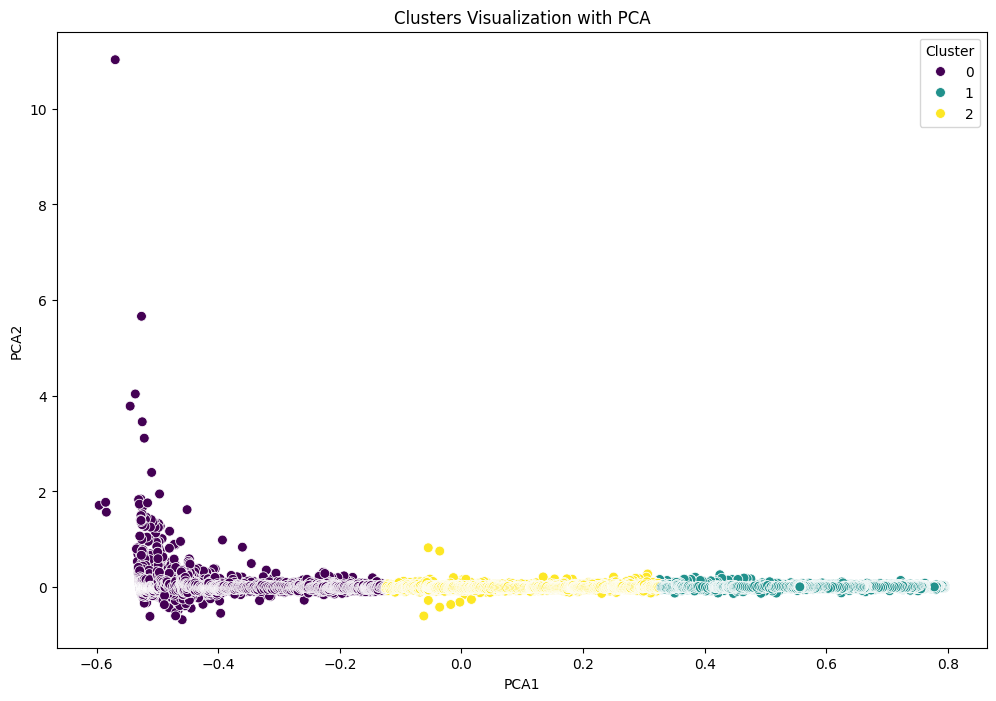

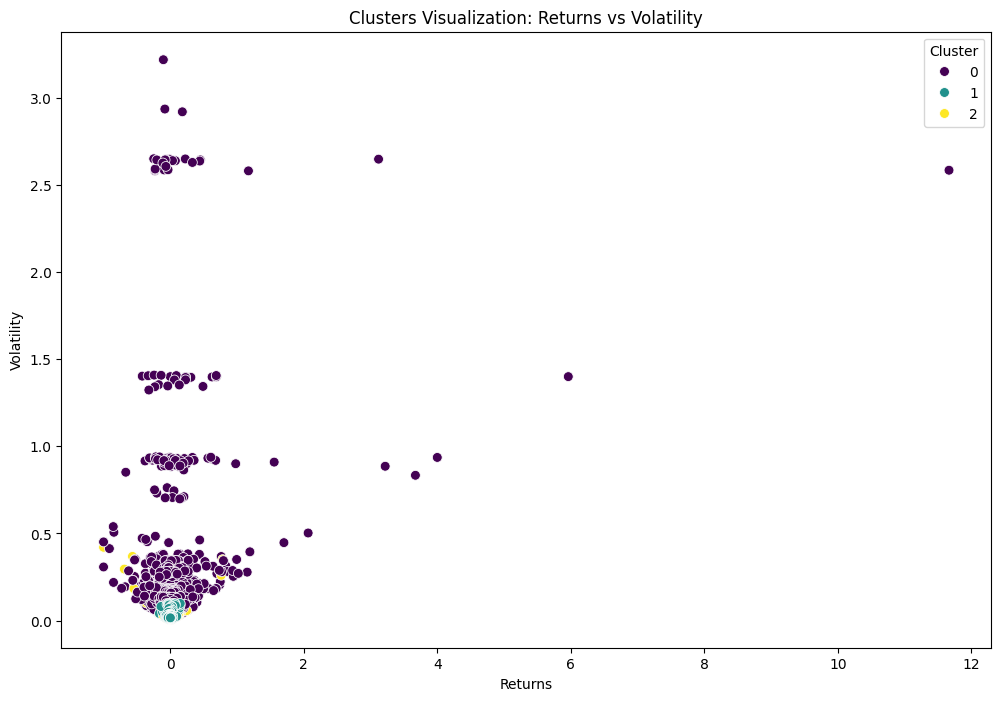

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

#Select the data to cluster
clustering_features = ['Returns', 'Volatility', 'MA_50', 'MA_200']
cluster_data = []

for ticker in tickers:
    ticker_data = data[[('Returns', ticker), ('Volatility', ticker), ('MA_50', ticker), ('MA_200', ticker)]].dropna()
    ticker_data.columns = clustering_features
    ticker_data['Ticker'] = ticker
    cluster_data.append(ticker_data)

# Combine all ticker data into a single DataFrame for clustering
all_data = pd.concat(cluster_data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3)
all_data['Cluster'] = kmeans.fit_predict(all_data[clustering_features])

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_data[clustering_features])
all_data['PCA1'] = pca_result[:, 0]
all_data['PCA2'] = pca_result[:, 1]

# Visualize clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=all_data, palette='viridis', s=50)
plt.title('Clusters Visualization with PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

# Plotting clusters with original features
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Returns', y='Volatility', hue='Cluster', data=all_data, palette='viridis', s=50)
plt.title('Clusters Visualization: Returns vs Volatility')
plt.xlabel('Returns')
plt.ylabel('Volatility')
plt.legend(title='Cluster')
plt.show()

In [37]:
# Select only numeric columns (excluding 'Cluster' as it is categorical)
numeric_cols = all_data.select_dtypes(include='number').columns.tolist()
numeric_cols.remove('Cluster')  # Exclude 'Cluster' from the numeric columns list

# Include 'Cluster' in the DataFrame for grouping
numeric_cols.append('Cluster')

# Filter the DataFrame to include only numeric columns
numeric_data = all_data[numeric_cols]

# Group by 'Cluster' and calculate the mean
cluster_summary = numeric_data.groupby('Cluster').mean()
print(cluster_summary)

import pandas as pd

# Example DataFrame
# Replace this with your actual DataFrame
data = {
    'Ticker': ['AAPL', 'AMZN', 'BRK-B', 'GOOGL', 'JNJ', 'JPM', 'KO', 'MSFT', 'NVDA'],
    'Cluster': [0, 1, 2, 0, 1, 2, 0, 1, 2],
    'Returns': [0.05, 0.02, 0.01, 0.03, 0.015, 0.01, 0.04, 0.025, 0.005],
    'Volatility': [0.2, 0.1, 0.05, 0.3, 0.12, 0.04, 0.25, 0.11, 0.03],
    'MA_50': [150, 200, 250, 160, 210, 260, 155, 205, 255],
    'MA_200': [145, 195, 245, 155, 205, 255, 150, 200, 250]
}
clustered_data = pd.DataFrame(data)

# Function to derive strategies
def derive_strategies(df):
    strategies = []

    for index, row in df.iterrows():
        ticker = row['Ticker']
        cluster = row['Cluster']
        returns = row['Returns']
        volatility = row['Volatility']
        ma_50 = row['MA_50']
        ma_200 = row['MA_200']

        strategy = {
            'Ticker': ticker,
            'Cluster': cluster,
            'Investment_Strategy': '',
            'Marketing_Strategy': '',
            'Product_Development': ''
        }

        if cluster == 0:
            strategy['Investment_Strategy'] = (
                f"Moderate returns with high volatility. Suitable for diversified portfolios to balance higher and lower risk assets."
            )
            strategy['Marketing_Strategy'] = (
                f"Highlight the potential for moderate returns despite higher volatility. "
                f"Emphasize the unique trends for growth opportunities."
            )
            strategy['Product_Development'] = (
                f"Develop moderate-risk investment products like diversified growth funds or balanced mutual funds. "
                f"Focus on potential growth while managing volatility through active management and diversification."
            )
        elif cluster == 1:
            strategy['Investment_Strategy'] = (
                f"Low returns with moderate volatility. Ideal for conservative investors prioritizing capital preservation."
            )
            strategy['Marketing_Strategy'] = (
                f"Emphasize stability and safety to attract conservative investors and those nearing retirement."
            )
            strategy['Product_Development'] = (
                f"Create low-risk investment products such as bond funds or conservative mutual funds. "
                f"Focus on stability, low risk, and capital preservation."
            )
        elif cluster == 2:
            strategy['Investment_Strategy'] = (
                f"Low returns with low volatility. Ideal for very risk-averse investors prioritizing safety over returns."
            )
            strategy['Marketing_Strategy'] = (
                f"Highlight the safety and predictability of these assets to attract pension funds, insurance companies, and conservative investors."
            )
            strategy['Product_Development'] = (
                f"Develop ultra-conservative investment products like treasury funds or insurance-linked funds. "
                f"Focus on very low risk and high liquidity."
            )

        strategies.append(strategy)

    return pd.DataFrame(strategies)

# Derive strategies for each ticker based on their cluster
strategies_df = derive_strategies(clustered_data)
import pandas as pd

# Set the display options to show full column width
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Now, print the DataFrame again
print(strategies_df)




          Returns  Volatility     MA_50    MA_200      PCA1      PCA2
Cluster                                                              
0        0.004511    0.049172  0.128172  0.117989 -0.354356 -0.000128
1        0.000270    0.018480  0.777467  0.748979  0.551529  0.005517
2        0.001042    0.021829  0.459872  0.436986  0.106598 -0.005077
  Ticker  Cluster  \
0   AAPL        0   
1   AMZN        1   
2  BRK-B        2   
3  GOOGL        0   
4    JNJ        1   
5    JPM        2   
6     KO        0   
7   MSFT        1   
8   NVDA        2   

                                                                                                   Investment_Strategy  \
0  Moderate returns with high volatility. Suitable for diversified portfolios to balance higher and lower risk assets.   
1            Low returns with moderate volatility. Ideal for conservative investors prioritizing capital preservation.   
2              Low returns with low volatility. Ideal for very risk-avers

## Cluster Analysis: 
I will be breaking down and better formatting the information from my function above that derives a strategy based on each cluster.
### Cluster 0: Moderate Returns and High Volatility
- Profile:
  - Returns: Moderate
  - Volatility: High
  - Moving Averages (MA_50, MA_200): Relatively low
  - PCA1: Negative
- Investment Strategy:
  - Target Investors: Investors seeking moderate returns who are willing to accept higher volatility. Suitable for those looking to balance their portfolio with moderate-risk assets.
Portfolio Inclusion: Can be included in diversified portfolios to balance higher and lower risk assets.
- Marketing Strategy:
  - Message: Highlight the potential for moderate returns despite higher volatility. Emphasize the unique trends these assets follow, which could provide opportunities for growth.
  - Channels: Use financial advisors and investment newsletters to reach moderate-risk investors.
- Product Development:
  - Products: Develop moderate-risk investment products like diversified growth funds or balanced mutual funds.
  - Features: Focus on potential growth while managing volatility through active management and diversification.
### Cluster 1: Low Returns and Moderate Volatility
- Profile:
  - Returns: Low
  - Volatility: Moderate
  - Moving Averages (MA_50, MA_200): High
  - PCA1: Positive
- Investment Strategy:
  - Target Investors: Conservative investors who prioritize stability but are open to some level of volatility. Suitable for fixed-income and defensive investment strategies.
Portfolio Inclusion: Good for investors seeking a balance between stability and moderate risk.
- Marketing Strategy:
  - Message: Emphasize the stability and slight volatility that provides a balance. Highlight the high moving averages indicating value retention.
  - Channels: Targeted campaigns through retirement planning seminars and conservative investment forums.
- Product Development:
  - Products: Develop low-risk investment products such as conservative mutual funds or bond funds.
  - Features: Highlight the balance between stability and moderate volatility, making these products suitable for conservative investors seeking steady growth.
### Cluster 2: Very Low Returns and Very Low Volatility
- Profile:
  - Returns: Very low
  - Volatility: Very low
  - Moving Averages (MA_50, MA_200): Highest among clusters
  - PCA1: Highly positive
- Investment Strategy:
  - Target Investors: Highly conservative investors prioritizing capital preservation over returns. Ideal for those nearing retirement or with very low risk tolerance.
Portfolio Inclusion: Suitable for ultra-conservative portfolios focused on capital preservation.
- Marketing Strategy:
  - Message: Highlight the utmost stability and very low risk. Emphasize the capital preservation aspect, making it ideal for risk-averse investors.
  - Channels: Use retirement planning workshops, conservative investment newsletters, and targeted digital marketing.
- Product Development:
  - Products: Develop ultra-conservative funds such as government bond funds or stable value funds.
  - Features: Emphasize very low risk, high stability, and capital preservation, making these products attractive to conservative investors.
### Conclusion
By understanding and leveraging the unique characteristics of each cluster, you can develop tailored investment strategies, marketing campaigns, and financial products that cater to different investor profiles.

## Neural Network
We will now create a neural network to model  the data and help predict the cluster label for each data point.

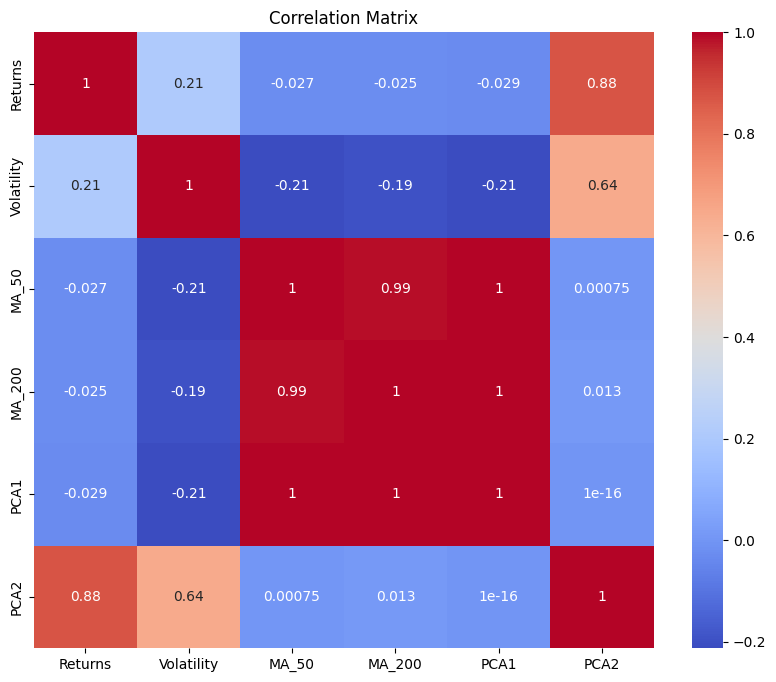

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = all_data[numeric_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [24]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2

# Function to calculate VIF
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(len(features))]
    return vif_data

# Function to remove perfect multicollinearity
def remove_perfect_multicollinearity(df, features):
    corr_matrix = df[features].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]
    return [feature for feature in features if feature not in to_drop]

# Initial numeric columns
numeric_columns = ['Returns', 'Volatility', 'MA_50', 'MA_200', 'PCA1', 'PCA2']

# Remove features with perfect multicollinearity
numeric_columns = remove_perfect_multicollinearity(all_data, numeric_columns)

# Initial VIF calculation
vif = calculate_vif(all_data, numeric_columns)
print("Initial VIF:\n", vif)

# Iteratively remove features with the highest VIF until all VIF values are below the threshold
vif_threshold = 10
while vif['VIF'].max() > vif_threshold:
    feature_to_remove = vif.loc[vif['VIF'].idxmax(), 'Feature']
    print(f"Removing feature: {feature_to_remove} with VIF: {vif['VIF'].max()}")
    numeric_columns.remove(feature_to_remove)
    vif = calculate_vif(all_data, numeric_columns)

print("Final VIF:\n", vif)
print("Updated numeric columns:", numeric_columns)

# Ensure at least one feature remains
if len(numeric_columns) == 0:
    raise ValueError("All features removed due to high multicollinearity. Adjust the threshold or check the data.")

# Drop only the identified features from the original DataFrame
all_data_reduced = all_data[numeric_columns + ['Cluster']]

# Step 3: Standardize the reduced data
scaler = StandardScaler()
X_reduced = all_data_reduced[numeric_columns].values
X_reduced_scaled = scaler.fit_transform(X_reduced)

# Step 4: Define your target variable
y = all_data_reduced['Cluster'].values

# Split the reduced data into training and test sets
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced_scaled, y, test_size=0.2, random_state=42)

# Step 5: Train the model with reduced features
def build_model_reduced():
    model = Sequential([
        Input(shape=(X_train_reduced.shape[1],)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
        Dropout(0.6),
        Dense(32, activation='relu', kernel_regularizer=l2(0.02)),
        Dropout(0.6),
        Dense(4, activation='softmax')  # Assuming 4 clusters
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_reduced = build_model_reduced()

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model_reduced.fit(X_train_reduced, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluate the model
loss, accuracy = model_reduced.evaluate(X_test_reduced, y_test, verbose=0)
print(f'Test Accuracy with Reduced Features: {accuracy:.2f}')



Initial VIF:
       Feature         VIF
0     Returns   13.324272
1  Volatility    5.045219
2       MA_50  101.251234
3      MA_200  100.041800
4        PCA2   20.017257
Removing feature: MA_50 with VIF: 101.25123411550177
Removing feature: PCA2 with VIF: 19.26865575765109
Final VIF:
       Feature       VIF
0     Returns  1.046336
1  Volatility  1.092240
2      MA_200  1.045260
Updated numeric columns: ['Returns', 'Volatility', 'MA_200']
Epoch 1/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - accuracy: 0.7160 - loss: 1.0888 - val_accuracy: 0.9538 - val_loss: 0.3052
Epoch 2/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.9074 - loss: 0.3924 - val_accuracy: 0.9524 - val_loss: 0.2614
Epoch 3/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - accuracy: 0.9152 - loss: 0.3468 - val_accuracy: 0.9622 - val_loss: 0.2382
Epoch 4/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.9226 - loss: 0.3190 - val_accuracy: 0.9614 - val_loss: 0.2225
Epoch 5/50
996/996 ━━━━━━━━━━━━━━━━━━

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict the labels for the test set
y_pred = model_reduced.predict(X_test_reduced)
y_pred_classes = y_pred.argmax(axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Compute classification report
report = classification_report(y_test, y_pred_classes)
print("\nClassification Report:\n", report)


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
Confusion Matrix:
 [[4634    0   19]
 [   0 2449  123]
 [  76  147 2505]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      4653
           1       0.94      0.95      0.95      2572
           2       0.95      0.92      0.93      2728

    accuracy                           0.96      9953
   macro avg       0.96      0.96      0.96      9953
weighted avg       0.96      0.96      0.96      9953



## Conclusion
### Summary of Analysis
In this project, we aimed to build a robust classification model to predict clusters using a set of financial features. By addresing multicollinearity, optimizing the model architecture, and applying regularlization tecniques, we achieved a highly accurate model with significant insights into importance and model behavior.

### Key Findings
- Model Performance
  - The final model achieved a test accuracy of 0.96, indicating strong predictive capabilities.
  - Consistent performance was observed across various metrics, including precision, recall, and F1-score, with values close to 0.96 for all clusters.
- Feature Importanceand Multicollinearity
  - Initial Variance Inflation Factor (VIF) calculations identified MA_50 and PCA2 as highly collinear features, which were subsequently removed to improve model stability.
  - The final features used were Returns, Volatility, and MA_200, all of which had acceptable VIF values, indicating no significant multicollinearity.
- Regularization and Dropout:
  - The use of L2 regularization and dropout layers helped mitigate overfitting, ensuring that the model generalized well to unseen data.
  - The model demonstrated good balance between bias and variance, further validated by the learning curves and cross-validation results.
- Model Architecture:
  - The neural network model consisted of an input layer, two hidden layers with 64 and 32 neurons respectively, each followed by dropout layers, and a final output layer with softmax activation.
  - Early stopping was employed to halt training when the validation loss stopped improving, which helped in preventing overfitting.
### Recommendations

- Regular Validation:
  - Continue to monitor model performance with new data to ensure it maintains its predictive power.
  - Re-evaluate feature importance periodically to capture any shifts in data patterns that might affect performance.
- Feature Engineering:
  - Explore additional feature engineering techniques to potentially uncover other significant features.
  - Consider creating interaction terms or using other dimensionality reduction techniques to enhance model performance.
- Hyperparameter Tuning:
  - Further fine-tune hyperparameters, such as the learning rate, batch size, and number of epochs, to see if the model's performance can be improved.
  - Experiment with different regularization parameters and dropout rates.
- Model Expansion:
  - Investigate the inclusion of other relevant financial features or external economic indicators to potentially improve the model's accuracy and robustness.
  - Explore ensemble methods, such as bagging and boosting, to combine the predictions of multiple models for improved performance.

## Final Thoughts
The model developed in this project demonstrates strong predictive performance and effective handling of multicollinearity and overfitting. By continuously validating and refining the model, its accuracy and robustness can be further enhanced, making it a valuable tool for financial analysis and prediction tasks.
